In [40]:
import numpy as np
from pycoingecko import CoinGeckoAPI
import requests
import snscrape.modules.twitter as sntwitter
import pandas as pd
import textwrap
import datetime as dt
import openai
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import TimeFrame
import re
import time
import pinecone
import matplotlib.pyplot as plt

# Data source: CoinMarketCap

In [16]:
import requests
import pandas as pd
from datetime import datetime, timedelta

API_KEY = "0c3be215-ae4b-4ec7-8050-04b7162d3e30"  # Replace with your actual API key
BASE_URL = "https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/historical"

headers = {
    'Accepts': 'application/json',
    'X-CMC_PRO_API_KEY': API_KEY,
}

# Calculate date range for the last 30 days
end_date = datetime.now()
start_date = end_date - timedelta(days=30)

parameters = {
    'start': '1',
    'limit': '250',  # Get data for the first 250 cryptocurrencies
    'convert': 'USD',
    'time_start': start_date.strftime('%Y-%m-%dT%H:%M:%SZ'),
    'time_end': end_date.strftime('%Y-%m-%dT%H:%M:%SZ')
}

response = requests.get(BASE_URL, headers=headers, params=parameters)
data = response.json()

if response.status_code == 200:
    crypto_data = data['data']
    statistics = []

    for coin in crypto_data:
        stats = coin['quote']['USD']
        statistics.append({
            'Name': coin['name'],
            'Symbol': coin['symbol'],
            'Price Change %': stats['percent_change_30d'],
            'Price Volatility %': stats['percent_change_30d'] - stats['percent_change_7d'],
            'Market Cap Change %': stats['market_cap_change_percentage_30d'],
            'Volume Change %': stats['volume_change_percentage_30d'],
        })

    df = pd.DataFrame(statistics)
    print(df)
else:
    print(f"Request failed with status code: {response.status_code}")


Request failed with status code: 403


# Data source: Price History CoinGecko

In [19]:
cryptos = [x['name'] for x in data['data']]


KeyError: 'data'

In [3]:
# get ustc data
cg = CoinGeckoAPI()
coins_list = cg.get_coins_list()

target_crypto_name = "ustc"

# Find the target cryptocurrency by its name
target_crypto = next((coin for coin in coins_list if coin['name'] == target_crypto_name), None)
if target_crypto:
    print("Cryptocurrency Information:")
    print(f"ID: {target_crypto['id']}")
    print(f"Symbol: {target_crypto['symbol']}")
    print(f"Name: {target_crypto['name']}")
else:
    print(f"Cryptocurrency '{target_crypto_name}' not found in the list.")

Cryptocurrency 'ustc' not found in the list.


In [30]:
start_date.timestamp()

1689359986.663349

In [31]:
end_date.timestamp()

1691951986.663349

In [44]:
from pycoingecko import CoinGeckoAPI
import pandas as pd
from datetime import datetime, timedelta

cg = CoinGeckoAPI()

# List of cryptocurrency IDs
crypto_list = ['bitcoin', 'ethereum', 'venus-xrp', 'shiba-inu', 'terrausd']


def compute_stats_for_crypto(crypto_ids):
    """
    Computes the statistics for a given cryptocurrency
    :param crypto_id: The ID of the cryptocurrency
    :return: A dictionary containing the statistics
    """
    statistics = []

    # Calculate date range for the last 30 days
    end_date = datetime.now()
    start_date = end_date - timedelta(days=30)

    for crypto_id in crypto_ids:
        crypto_data = cg.get_coin_market_chart_range_by_id(
            id=crypto_id,
            vs_currency='usd',  # You can change the currency here
            from_timestamp=int(start_date.timestamp()),
            to_timestamp=int(end_date.timestamp())
        )
        # price changes
        prices = [entry[1] for entry in crypto_data['prices']]
        price_changes = [(b - a) / a * 100 for a, b in zip(prices, prices[1:])]

        # calculate trend
        time_intervals = np.arange(len(prices))
        slope, _ = np.polyfit(time_intervals, prices, 1)

        if slope > 0:
            trend = 'Positive'
        elif slope < 0:
            trend = 'Negative'
        else:
            trend = 'No Change'
        

        statistics.append({
            'Name': crypto_id,
            'Prices': prices,
            'Price Change %': price_changes,
            'Market Cap Change %': [entry[1] for entry in crypto_data['market_caps']],
            'Volume Change %': [entry[1] for entry in crypto_data['total_volumes']],
            'Slope': slope,
            'Trend': trend
        })


    df = pd.DataFrame(statistics)

    # Calculate additional statistics
    df['Price Change % Min'] = df['Price Change %'].apply(min)
    df['Price Change % Max'] = df['Price Change %'].apply(max)
    df['Price Change % Average'] = df['Price Change %'].apply(lambda x: sum(x) / len(x))

    df['Market Cap Change % Min'] = df['Market Cap Change %'].apply(min)
    df['Market Cap Change % Max'] = df['Market Cap Change %'].apply(max)
    df['Market Cap Change % Average'] = df['Market Cap Change %'].apply(lambda x: sum(x) / len(x))

    df['Volume Change % Min'] = df['Volume Change %'].apply(min)
    df['Volume Change % Max'] = df['Volume Change %'].apply(max)
    df['Volume Change % Average'] = df['Volume Change %'].apply(lambda x: sum(x) / len(x))

    return df


crypto_df = compute_stats_for_crypto(crypto_list)


In [46]:
crypto_df.columns

Index(['Name', 'Prices', 'Price Change %', 'Market Cap Change %',
       'Volume Change %', 'Slope', 'Trend', 'Price Change % Min',
       'Price Change % Max', 'Price Change % Average',
       'Market Cap Change % Min', 'Market Cap Change % Max',
       'Market Cap Change % Average', 'Volume Change % Min',
       'Volume Change % Max', 'Volume Change % Average'],
      dtype='object')

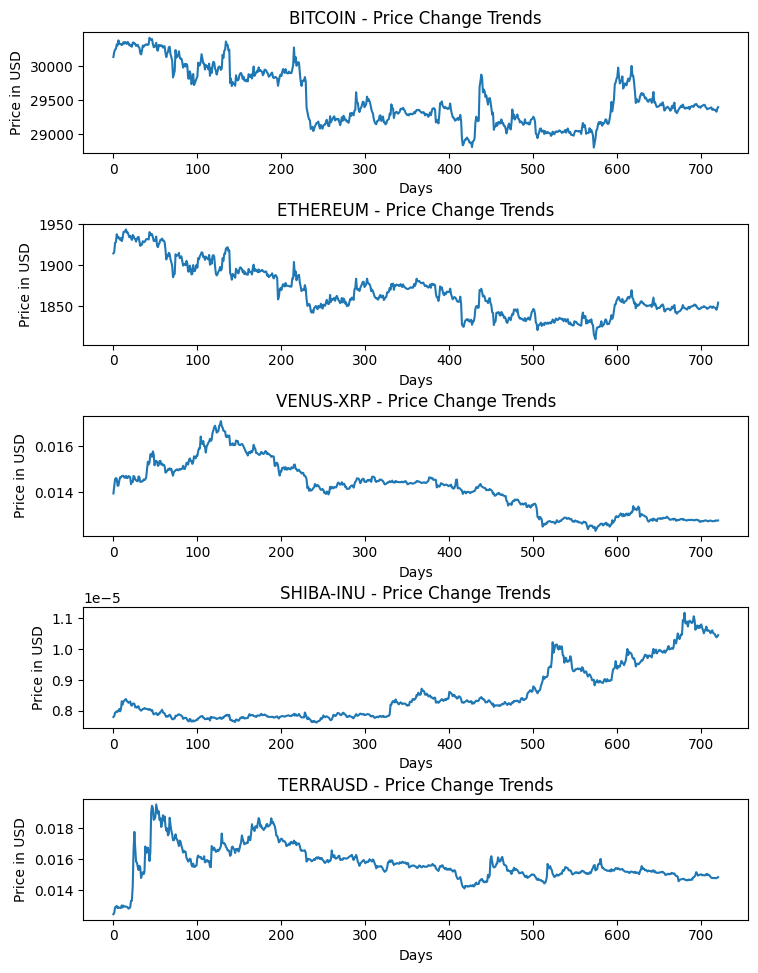

In [58]:

# Create subplots
num_crypto = len(crypto_list)
fig, axs = plt.subplots(num_crypto, 1, figsize=(8, 2 * num_crypto))
fig.tight_layout(pad=3.0)

for idx, row in crypto_df.iterrows():
    axs[idx].plot(row['Prices'])
    axs[idx].set_title(f"{row['Name'].upper()} - Prices")
    axs[idx].set_xlabel('Days')
    axs[idx].set_ylabel('Price in USD')


# News Sentiment Analysis

In [59]:
symbols = ["bitcoin", "shiba-inu", "xrp", "utsc", "ethereum"]

def get_all_crypto_news():
    API_KEY = "2c63d5eeb8444fb981a0bb3c463fbfa9"
    all_news = {}

    for symbol in symbols:
        url = f'https://newsapi.org/v2/everything?q={symbol}&apiKey={API_KEY}'
        response = requests.get(url)
        data = response.json()

        news_data = []
        try:
            for article in data['articles'][:3]:  # Limit to top 3 articles
                news_data.append({
                    'title': article['title'],
                    'source': article['source']['name'],
                })
            all_news[symbol] = news_data
        except:
            return all_news

    return all_news

news_output = get_all_crypto_news()
print(textwrap.fill(str(news_output), width=50))

{'bitcoin': [{'title': 'SEC Reportedly Asked
Coinbase to Halt All Trading—Except for Bitcoin',
'source': 'Gizmodo.com'}, {'title': "Everyone's
Favorite Knife-Wielding Robot Returns in Next
Week's Futurama", 'source': 'Gizmodo.com'},
{'title': 'PayPal launches PYUSD stablecoin backed
by the US dollar', 'source': 'The Verge'}],
'shiba-inu': [{'title': 'Elon Really Wants to Turn
Twitter Into Wall Street', 'source':
'Gizmodo.com'}, {'title': 'Twitter: Elon Musk says
he wants to change company’s bird logo', 'source':
'The Guardian'}, {'title': 'Shiba Inu: Bull or
Bear?', 'source': 'Motley Fool'}], 'xrp':
[{'title': "US securities regulator 'disappointed'
with defeat over Ripple's XRP - Reuters",
'source': 'Google News'}, {'title': 'Judge gives
Ripple partial win in SEC case over XRP
cryptocurrency - Reuters', 'source': 'Google
News'}, {'title': 'Bitcoin was the only
cryptocurrency the SEC asked Coinbase not to
delist, CEO says', 'source': 'Business Insider'}],
'utsc': [{'title': 'An unlikel

# Twitter sentiment

In [60]:
queries = ["bitcoin", "shiba-inu", "xrp", "utsc", "ethereum"]
tweets_list = []

for query in queries:
    num = 0
    for tweet in sntwitter.TwitterSearchScraper(query).get_items():
        if num == 10:
            break
        num += 1
        tweets_list.append(tweet.rawContent)
        print(tweet.rawContent)

Error retrieving https://twitter.com/i/api/graphql/7jT5GT59P8IFjgxwqnEdQw/SearchTimeline?variables=%7B%22rawQuery%22%3A%22bitcoin%22%2C%22count%22%3A20%2C%22product%22%3A%22Latest%22%2C%22withDownvotePerspective%22%3Afalse%2C%22withReactionsMetadata%22%3Afalse%2C%22withReactionsPerspective%22%3Afalse%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Afalse%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_translatable_rweb_tweet_is_translatable_enabled%22%3Atrue%2C%22view_counts_everywhere_api_enable

ScraperException: 4 requests to https://twitter.com/i/api/graphql/7jT5GT59P8IFjgxwqnEdQw/SearchTimeline?variables=%7B%22rawQuery%22%3A%22bitcoin%22%2C%22count%22%3A20%2C%22product%22%3A%22Latest%22%2C%22withDownvotePerspective%22%3Afalse%2C%22withReactionsMetadata%22%3Afalse%2C%22withReactionsPerspective%22%3Afalse%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Afalse%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_translatable_rweb_tweet_is_translatable_enabled%22%3Atrue%2C%22view_counts_everywhere_api_enabled%22%3Atrue%2C%22longform_notetweets_consumption_enabled%22%3Atrue%2C%22tweet_awards_web_tipping_enabled%22%3Afalse%2C%22freedom_of_speech_not_reach_fetch_enabled%22%3Afalse%2C%22standardized_nudges_misinfo%22%3Atrue%2C%22tweet_with_visibility_results_prefer_gql_limited_actions_policy_enabled%22%3Afalse%2C%22interactive_text_enabled%22%3Atrue%2C%22responsive_web_text_conversations_enabled%22%3Afalse%2C%22longform_notetweets_rich_text_read_enabled%22%3Afalse%2C%22longform_notetweets_inline_media_enabled%22%3Afalse%2C%22responsive_web_enhance_cards_enabled%22%3Afalse%2C%22responsive_web_twitter_blue_verified_badge_is_enabled%22%3Atrue%7D failed, giving up.